In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.head()

,clean_comment,category
0,"film absolutely awful, but nevertheless, hilar...",0
1,well since seeing part 1 3 honestly say never ...,0
2,got see film preview dazzled it. not typical r...,1
3,adaptation positively butcher classic beloved ...,0
4,rzone awful movie! simple. seems tried make mo...,0


In [5]:
X = df['clean_comment']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
def run_experiment(vectorizer_type, ngram_range, max_features=5000):
    # Vectorization
    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)

    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Logistic Regression + RandomizedSearchCV
    param_dist = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200, 300]
    }

    clf = LogisticRegression(random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        clf, param_distributions=param_dist, n_iter=5,
        scoring='f1_macro', n_jobs=-1, cv=cv, random_state=42, verbose=0
    )

    random_search.fit(X_train_vec, y_train)

    # Predictions
    y_pred = random_search.predict(X_test_vec)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {vectorizer_type} {ngram_range}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Save model and vectorizer
    model_filename = f'logreg_{vectorizer_type}_{ngram_range}.pkl'
    vectorizer_filename = f'vectorizer_{vectorizer_type}_{ngram_range}.pkl'

    with open(model_filename, 'wb') as f:
        pickle.dump(random_search.best_estimator_, f)
    with open(vectorizer_filename, 'wb') as f:
        pickle.dump(vectorizer, f)

    # Return results
    return {
        'vectorizer_type': vectorizer_type,
        'ngram_range': ngram_range,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'best_params': random_search.best_params_,
        'model': random_search.best_estimator_,
        'vectorizer': vectorizer
    }

Running experiment: BoW with ngram (1, 1)


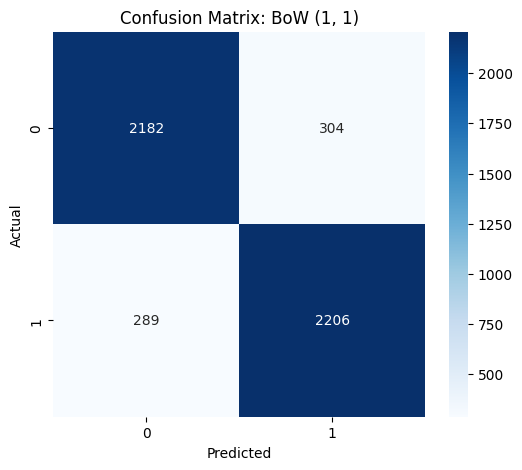

Running experiment: BoW with ngram (1, 2)


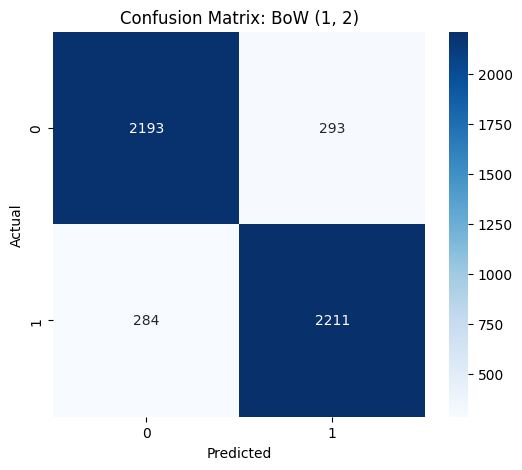

Running experiment: BoW with ngram (1, 3)


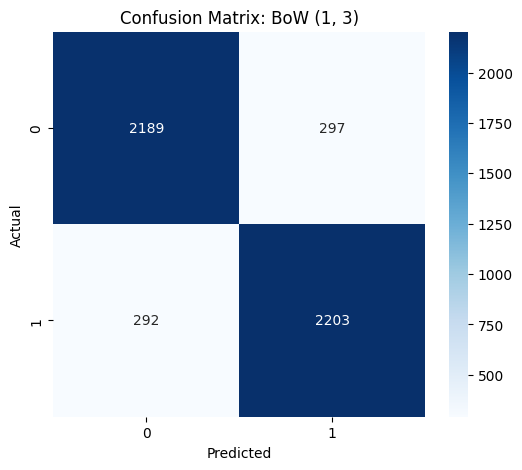

Running experiment: TF-IDF with ngram (1, 1)


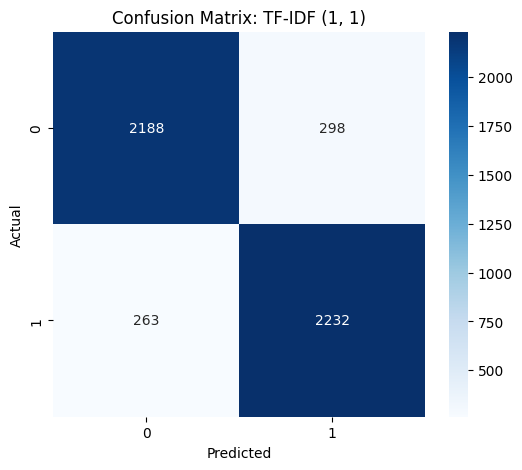

Running experiment: TF-IDF with ngram (1, 2)


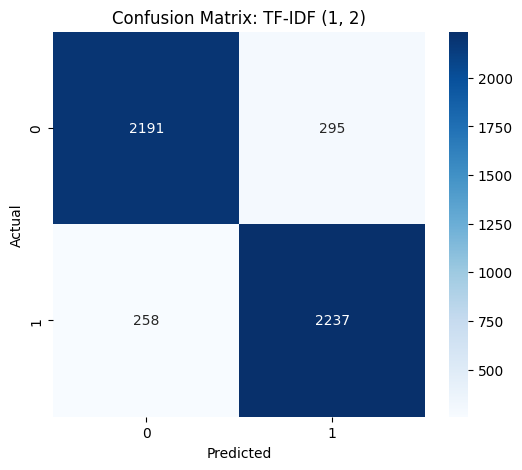

Running experiment: TF-IDF with ngram (1, 3)


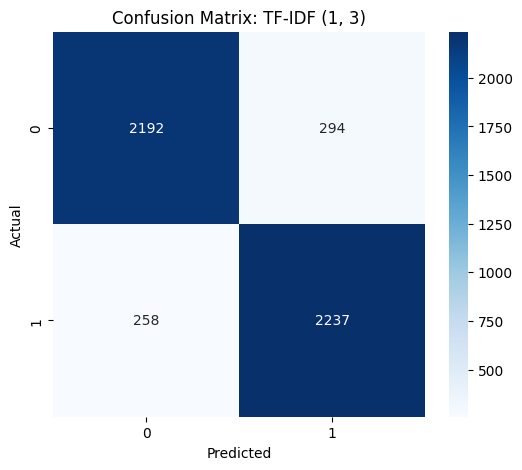

In [7]:
ngram_options = [(1,1), (1,2), (1,3)]
vectorizers = ["BoW", "TF-IDF"]
results = []

for vec in vectorizers:
    for ngram in ngram_options:
        print(f"Running experiment: {vec} with ngram {ngram}")
        result = run_experiment(vec, ngram, max_features=5000)
        results.append(result)

In [8]:
results_df = pd.DataFrame(results)
best_idx = results_df['f1'].idxmax()
best_result = results[best_idx]

print("\nBest Result:")
print(best_result)


Best Result:
{'vectorizer_type': 'TF-IDF', 'ngram_range': (1, 3), 'accuracy': 0.8891788797430235, 'precision': 0.8892671284238705, 'recall': 0.8891654588339994, 'f1': 0.8891698338816436, 'best_params': {'solver': 'lbfgs', 'max_iter': 200, 'C': 1}, 'model': LogisticRegression(C=1, max_iter=200, random_state=42), 'vectorizer': TfidfVectorizer(max_features=5000, ngram_range=(1, 3))}


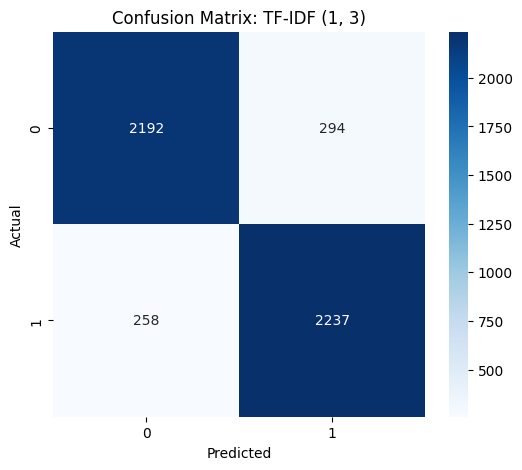

In [9]:
X_test_vec_best = best_result['vectorizer'].transform(X_test)
y_pred_best = best_result['model'].predict(X_test_vec_best)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix: {best_result['vectorizer_type']} {best_result['ngram_range']}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
new_text = ["i heat this movie"]

new_text_vec = best_result['vectorizer'].transform(new_text)
prediction = best_result['model'].predict(new_text_vec)
print("Predicted category:", prediction[0])

Predicted category: 0


In [17]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.head()

,clean_comment,category
0,"film absolutely awful, but nevertheless, hilar...",0
1,well since seeing part 1 3 honestly say never ...,0
2,got see film preview dazzled it. not typical r...,1
3,adaptation positively butcher classic beloved ...,0
4,rzone awful movie! simple. seems tried make mo...,0


In [18]:
X = df['clean_comment']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 19923, Test samples: 4981


In [19]:
def run_experiment_tfidf_logreg(max_features):
    ngram_range = (1, 3)  # Trigrams
    
    # TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    # Logistic Regression + RandomizedSearchCV
    param_dist = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200, 300]
    }
    
    clf = LogisticRegression(random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    random_search = RandomizedSearchCV(
        clf, param_distributions=param_dist, n_iter=5,
        scoring='f1_macro', n_jobs=-1, cv=cv, random_state=42, verbose=0
    )
    
    random_search.fit(X_train_vec, y_train)
    
    # Predictions
    y_pred = random_search.predict(X_test_vec)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (max_features={max_features})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Save model and vectorizer as .pkl
    model_filename = f'logreg_tfidf_maxfeatures_{max_features}.pkl'
    vectorizer_filename = f'vectorizer_tfidf_maxfeatures_{max_features}.pkl'
    
    with open(model_filename, 'wb') as f:
        pickle.dump(random_search.best_estimator_, f)
    with open(vectorizer_filename, 'wb') as f:
        pickle.dump(vectorizer, f)
    
    print(f"Model & Vectorizer saved for max_features={max_features}")
    
    return {
        'max_features': max_features,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'best_params': random_search.best_params_
    }


Running experiment for max_features=1000


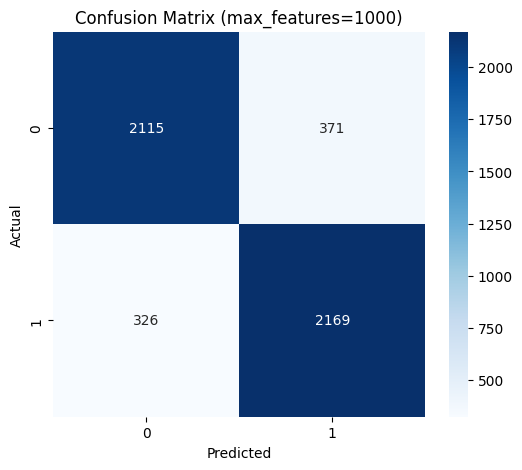

Model & Vectorizer saved for max_features=1000

Running experiment for max_features=2000


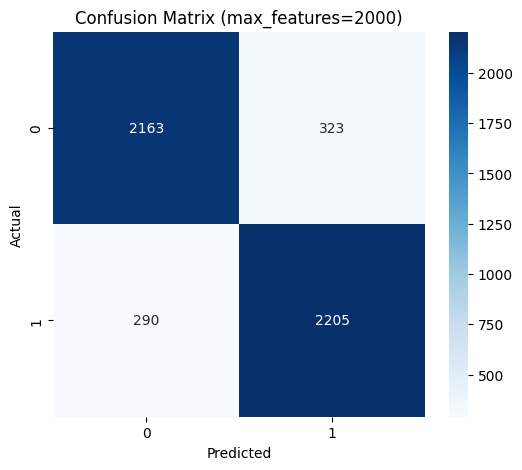

Model & Vectorizer saved for max_features=2000

Running experiment for max_features=3000


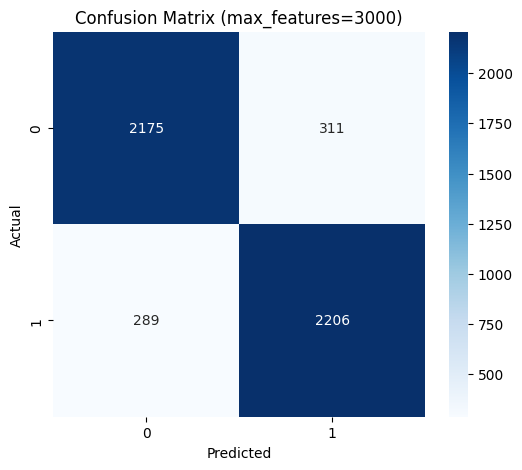

Model & Vectorizer saved for max_features=3000

Running experiment for max_features=4000


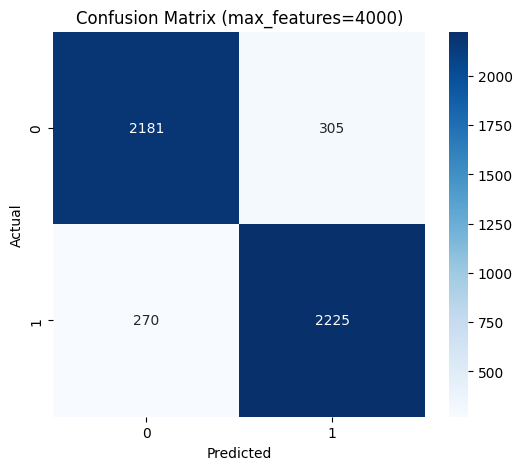

Model & Vectorizer saved for max_features=4000

Running experiment for max_features=5000


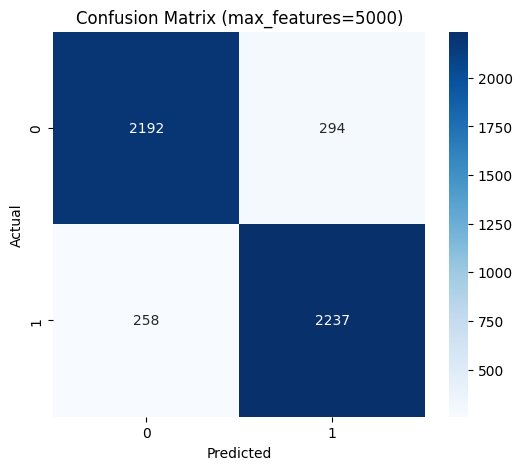

Model & Vectorizer saved for max_features=5000

Running experiment for max_features=6000


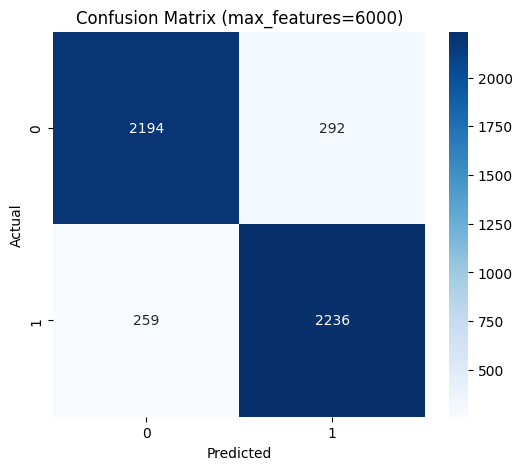

Model & Vectorizer saved for max_features=6000

Running experiment for max_features=7000


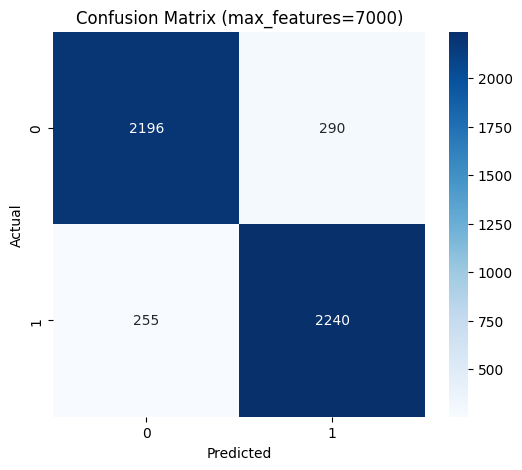

Model & Vectorizer saved for max_features=7000

Running experiment for max_features=8000


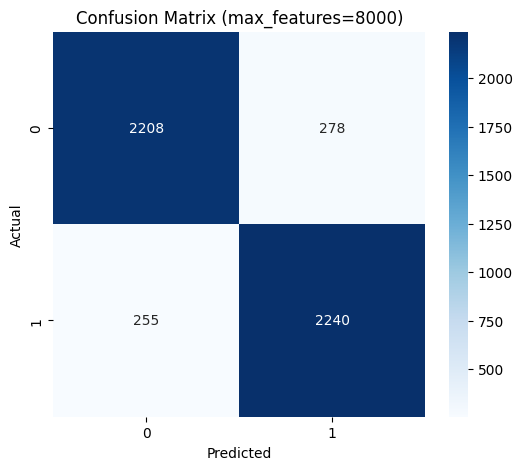

Model & Vectorizer saved for max_features=8000

Running experiment for max_features=9000


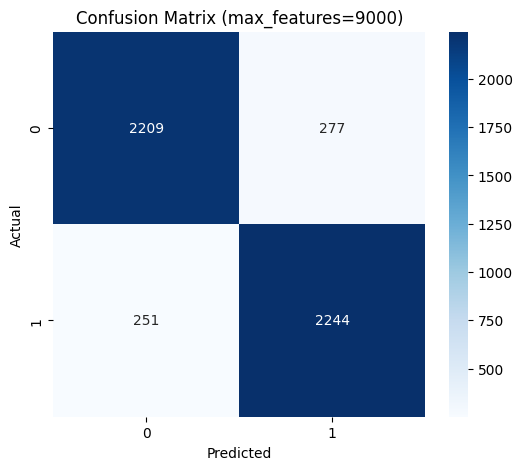

Model & Vectorizer saved for max_features=9000

Running experiment for max_features=10000


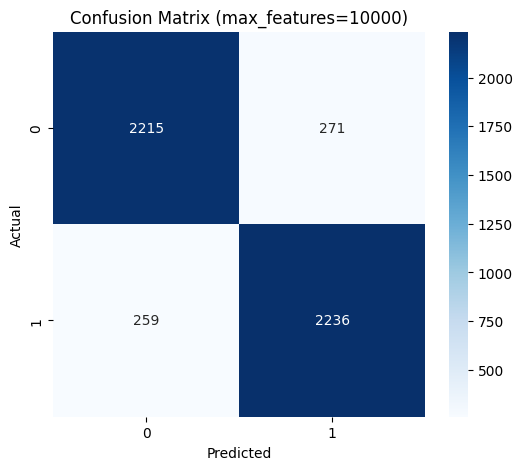

Model & Vectorizer saved for max_features=10000


In [22]:
max_features_values = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,10000]

results = []

for max_feat in max_features_values:
    print(f"\nRunning experiment for max_features={max_feat}")
    result = run_experiment_tfidf_logreg(max_feat)
    results.append(result)

In [23]:
results_df = pd.DataFrame(results)
best_idx = results_df['f1'].idxmax()
best_result = results_df.loc[best_idx]

print("\nBest Result:")
print(best_result)


Best Result:
max_features                                             9000
accuracy                                             0.893997
precision                                            0.894045
recall                                               0.893987
f1                                                   0.893992
best_params     {'solver': 'lbfgs', 'max_iter': 300, 'C': 10}
Name: 8, dtype: object


In [25]:
best_max_features = best_result['max_features']

# Load model and vectorizer
with open(f'logreg_tfidf_maxfeatures_{best_max_features}.pkl', 'rb') as f:
    best_model = pickle.load(f)
with open(f'vectorizer_tfidf_maxfeatures_{best_max_features}.pkl', 'rb') as f:
    best_vectorizer = pickle.load(f)

# Example new text
new_text = ["This movie was terrible. I love every minute of it!"]

new_text_vec = best_vectorizer.transform(new_text)
prediction = best_model.predict(new_text_vec)

print("Predicted category:", prediction[0])

Predicted category: 0


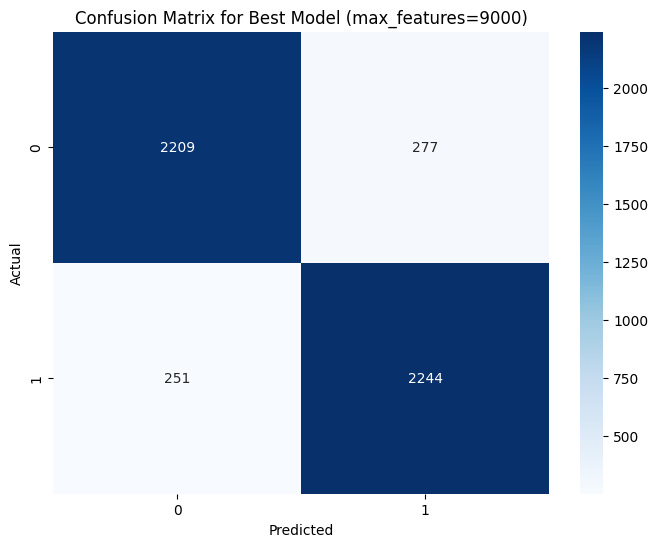

In [27]:
# Transform test data with best vectorizer
X_test_vec_best = best_vectorizer.transform(X_test)

# Predict with best model
y_pred_best = best_model.predict(X_test_vec_best)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for Best Model (max_features={best_max_features})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()